<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/RouteLLM_BT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RouteLLM BT Model Approach
The paper "RouteLLM" Suggests a few approaches to LLM Routing. Tthis is the Bradley-Terry Approach

# Defining Main Dataset

In [1]:
import pandas as pd

df = pd.read_csv("hf://datasets/lmsys/lmsys-arena-human-preference-55k/train.csv")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


In [3]:
# Initialize the ELO ratings for each model
elo_ratings = {}

def get_elo(model):
    """Get the ELO rating for a model, defaulting to 1000."""
    return elo_ratings.get(model, 1000)

def update_elo(winner, loser, k=32, draw=False):
    """Update ELO ratings for a winner and loser model, or in case of a draw."""
    winner_elo = get_elo(winner)
    loser_elo = get_elo(loser)

    # Calculate expected scores
    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    expected_loser = 1 / (1 + 10 ** ((winner_elo - loser_elo) / 400))

    # Define the score outcome
    if draw:
        winner_score = loser_score = 0.5
    else:
        winner_score = 1
        loser_score = 0

    # Update ratings
    elo_ratings[winner] = winner_elo + k * (winner_score - expected_winner)
    elo_ratings[loser] = loser_elo + k * (loser_score - expected_loser)

# Process each row in the DataFrame to update the ELO ratings
for _, row in df.iterrows():
    model_a = row['model_a']
    model_b = row['model_b']

    if row['winner_model_a'] == 1:
        update_elo(model_a, model_b)
    elif row['winner_model_b'] == 1:
        update_elo(model_b, model_a)
    elif row['winner_tie'] == 1:
        update_elo(model_a, model_b, draw=True)

# Convert ELO ratings to a DataFrame for easy viewing
elo_df = pd.DataFrame(list(elo_ratings.items()), columns=['Model', 'ELO Rating']).sort_values(by='ELO Rating', ascending=False)
elo_df.reset_index(drop=True, inplace=True)

# Display the DataFrame using tabulate for a cleaner output
elo_df

,Model,ELO Rating
0,gpt-4-0125-preview,1247.307756
1,gpt-3.5-turbo-0613,1174.807565
2,gpt-4-1106-preview,1173.268998
3,gpt-4-0314,1130.541965
4,tulu-2-dpo-70b,1127.553508
...,...,...
59,oasst-pythia-12b,827.413651
60,stablelm-tuned-alpha-7b,809.281896
61,chatglm-6b,752.394747
62,llama-13b,729.849219


In [4]:
# Grouping into 10 groups
n = 10
elo_df['Group'] = pd.qcut(elo_df['ELO Rating'], q=n, labels=False)
elo_df['Group'] = n-1-elo_df['Group']

# Display the grouped DataFrame
elo_df

,Model,ELO Rating,Group
0,gpt-4-0125-preview,1247.307756,0
1,gpt-3.5-turbo-0613,1174.807565,0
2,gpt-4-1106-preview,1173.268998,0
3,gpt-4-0314,1130.541965,0
4,tulu-2-dpo-70b,1127.553508,0
...,...,...,...
59,oasst-pythia-12b,827.413651,9
60,stablelm-tuned-alpha-7b,809.281896,9
61,chatglm-6b,752.394747,9
62,llama-13b,729.849219,9


In [5]:
strong_models = elo_df[elo_df.Group <=1]['Model'].unique()
strong_models

array(['gpt-4-0125-preview', 'gpt-3.5-turbo-0613', 'gpt-4-1106-preview',
       'gpt-4-0314', 'tulu-2-dpo-70b', 'llama-2-70b-chat',
       'qwen1.5-72b-chat', 'nous-hermes-2-mixtral-8x7b-dpo', 'gemini-pro',
       'mixtral-8x7b-instruct-v0.1', 'llama-2-7b-chat', 'mistral-medium',
       'wizardlm-70b'], dtype=object)

In [6]:
weak_models = elo_df[(elo_df.Group>1) & (elo_df.Group<=3)]['Model'].unique()
weak_models

array(['gpt-3.5-turbo-0314', 'gpt-3.5-turbo-0125',
       'openhermes-2.5-mistral-7b', 'pplx-70b-online', 'claude-2.0',
       'gpt-4-0613', 'gemini-pro-dev-api', 'claude-2.1', 'claude-1',
       'llama2-70b-steerlm-chat', 'deepseek-llm-67b-chat',
       'solar-10.7b-instruct-v1.0', 'wizardlm-13b'], dtype=object)

In [7]:
# Filter rows where there's a match between a strong and a weak model
matches = df[((df['model_a'].isin(strong_models)) & (df['model_b'].isin(weak_models))) |
             ((df['model_a'].isin(weak_models)) & (df['model_b'].isin(strong_models)))].copy()

# Reconstruct DataFrame to show whether strong or weak model won
def identify_winner(row):
    if row['model_a'] in strong_models and row['winner_model_a'] == 1:
        return 'strong'
    elif row['model_b'] in strong_models and row['winner_model_b'] == 1:
        return 'strong'
    elif row['model_a'] in weak_models and row['winner_model_a'] == 1:
        return 'weak'
    elif row['model_b'] in weak_models and row['winner_model_b'] == 1:
        return 'weak'
    else:
        return 'tie'

# Apply the identify_winner function to create a new column
matches.loc[:, 'Winner'] = matches.apply(identify_winner, axis=1)  # Use .loc to set the new column

# Select and rearrange columns for clarity
result_df = matches[['Winner', 'prompt']]
result_df

,Winner,prompt
0,strong,"[""Is it morally right to try to have a certain..."
7,weak,"[""\""Bacteria is life on Mars but a heartbeat i..."
22,tie,"[""Can you explain what the Cypher Query Langua..."
24,tie,"[""Can you write a story about a lifeguard name..."
26,tie,"[""could you tell a funny and whimsical story a..."
...,...,...
57465,strong,"[""please describe how the following two statem..."
57466,strong,"[""this is a simulation. 37 years old, white ma..."
57467,strong,"[""can you provide a modular python code that w..."
57470,strong,"[""I want you to act like {character} from {ser..."


In [8]:
result_df.Winner.value_counts()

,count
Winner,
strong,4606
tie,3335
weak,3174


# Note
RouteLLM augments this data with golden lable data and LLM as judge data. We won't do that here.

# Routing with BT model

Using a Bradley-Terry model with embeddings to decide which model class to route to

In [9]:
!pip install openai
!pip install langchain-community
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.15
    Uninstalling langchain-core-0.3.15:
      Successfully uninstalled langchain-core-0.3.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.1 MB/s eta 0:00:00


## Embedding Data

In [10]:
from google.colab import userdata
import openai
import os

api_key = userdata.get('OpenAIAPIKey')
os.environ['OPENAI_API_KEY'] = api_key

In [11]:
import numpy as np
import pandas as pd
from langchain.embeddings import OpenAIEmbeddings

# Initialize the LangChain OpenAI embeddings model
embeddings_model = OpenAIEmbeddings(model="text-embedding-ada-002")  # Use the small model

# Get batch embeddings for all prompts in result_df
prompts = result_df['prompt'].tolist()

#sanatizing
prompts = [p.replace('<|endoftext|>', '') for p in prompts]

result_df['prompt_embedding'] = embeddings_model.embed_documents(prompts)

<ipython-input-11-bcf021f30eac>:6: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings_model = OpenAIEmbeddings(model="text-embedding-ada-002")  # Use the small model
<ipython-input-11-bcf021f30eac>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['prompt_embedding'] = embeddings_model.embed_documents(prompts)


In [12]:
result_df

,Winner,prompt,prompt_embedding
0,strong,"[""Is it morally right to try to have a certain...","[0.016110674600082704, -0.02285776545015528, 0..."
7,weak,"[""\""Bacteria is life on Mars but a heartbeat i...","[-0.010212965153490029, -0.002264541306372864,..."
22,tie,"[""Can you explain what the Cypher Query Langua...","[0.0214463146508967, 0.008269389523151266, 0.0..."
24,tie,"[""Can you write a story about a lifeguard name...","[2.6210532231287662e-05, -0.000634177259772841..."
26,tie,"[""could you tell a funny and whimsical story a...","[0.015002578925881449, -0.008475396619294216, ..."
...,...,...,...
57465,strong,"[""please describe how the following two statem...","[0.0053320008910354095, 0.008999157480533974, ..."
57466,strong,"[""this is a simulation. 37 years old, white ma...","[-0.02408318648581002, 0.0017563447287897128, ..."
57467,strong,"[""can you provide a modular python code that w...","[0.016568595443204243, 0.021091258025641487, -..."
57470,strong,"[""I want you to act like {character} from {ser...","[-0.01874203756635266, 0.012563647453844166, 0..."


# Creating Similarity Based Routing

In [13]:
import numpy as np

def calculate_weight(new_query_embedding, training_query_embeddings, gamma=10):
    """Returns a weight for each training query embedding via normalized cosine similarity.
    Parameters:
    - new_query_embedding: numpy array of shape [embedding_dim], the embedding of the new query.
    - training_query_embeddings: numpy array of shape [N, embedding_dim], embeddings of training queries.
    - gamma: float, scaling factor for the weight calculation.
    Returns:
    - weights: numpy array of shape [N], weights for each training query embedding.
    """

    #calculating cosine similarity of the new query vs all training queries
    dot = np.dot(training_query_embeddings, new_query_embedding)
    norms_training = np.linalg.norm(training_query_embeddings, axis=1, keepdims=True)
    norm_new = np.linalg.norm(new_query_embedding)
    cosine_similarities = (dot/(norms_training.T*norm_new))[0]

    #Normalizing cosine similarities by max value
    normalized_similarities = cosine_similarities/max(cosine_similarities)

    #calculating weight
    return gamma ** (1+normalized_similarities)

# Testing with sample data
# Create a random embedding for the new query
np.random.seed(0)
new_query_embedding = np.random.rand(10)

# Create random embeddings for training queries
training_query_embeddings = np.random.rand(10, 10)

# Calculate weights
weights = calculate_weight(new_query_embedding, training_query_embeddings, gamma=10)
weights

array([ 82.70779993,  95.36947674, 100.        ,  72.57732008,
        72.75448222,  65.91411544,  60.36960324,  65.01629365,
        71.35973296,  74.87936352])

# Minimizing Weighted Binary Cross Entropy To Find Parameters

In [97]:
def compute_coefficients(weights, labels, learning_rate=0.01, epochs=20):
    """Computes the Bradley-Terry Coefficients based on the weights and labels for each query.

    Parameters:
    - weights: numpy array of shape [N], weights for each training query embedding.
    - labels: numpy array of shape [N], binary labels (0 or 1) for each training example.
    - learning_rate: float, learning rate for gradient descent.
    - epochs: int, number of iterations for gradient descent.

    Returns:
    - xi: numpy array of shape [2], optimized BT coefficients for small and large models
    """

    def binary_cross_entropy_loss(label, probability):
        """Calculate binary cross-entropy loss for a single example with probability clipping to avoid log(0)."""
        epsilon = 1e-10  # Small value to prevent log(0)
        probability = np.clip(probability, epsilon, 1 - epsilon)
        return -(label * np.log(probability) + (1 - label) * np.log(1 - probability))

    # Initialize coefficients (xi) randomly, one for each class
    # In the RouteLLM paper they learn one coefficient for 10 parititions,
    # But I found the details to be confusing. I'm computing coefficients for
    # small models and large models as we defined previously

    #the labels represent if large is necessary (1) or not (0), so index 0
    #of this should represent the coefficient of the large model not being
    #necessary, and index 1 represents the coefficient large model being
    #necessary. These coefficients will be optimized to bias one vs the other.

    # note: The BT model is optimized for *every query*, meaning
    # these will be optimized based on the similarities weights
    # for an individual case.
    xi = np.random.rand(2)

    #if there's a strong bias towards one model or the other throughout the data,
    # the BT model will learn that bias heavily, and thus won't learn routing nuance.
    #As a result, we're going to balance against that bias by biasing the gradient
    #of the loss when the label indicates a large model. If the large model is
    #called more often in the training, then this value will be <1. If less often,
    #this value will be >1.
    large_model_bias = 1/(labels.sum()/len(labels))


    for epoch in range(epochs):
        total_loss = 0
        gradients = np.zeros_like(xi)

        for i, (weight, label) in enumerate(zip(weights, labels)):
            # Calculate the probability using the Bradley-Terry model
            # this essentially asks the bradley terry model, based on the two
            # coefficients, how likely it is that a large model is necessary (1)
            delta = np.clip(xi[1] - xi[0], -500, 500)  # Clipping to prevent overflow in exp
            probability = 1 / (1 + np.exp(-delta)) #probability of a large model being required

            # Calculate the cross-entropy loss
            loss = binary_cross_entropy_loss(label, probability)
            weighted_loss = weight * loss
            total_loss += weighted_loss

            #Scaling loss if the model is large, according to bias
            if label:
                loss = large_model_bias*loss

            # Calculating gradients
            # Here I'm seperatly defining the direction to push the gradients,
            # based on the label, and the magnitude of that push based on the
            # weight and loss.

            # direction is based on if the prediction should be towards large
            # +1 for towards large, -1 for towards small
            direction = (label*2-1)

            gradient_large = direction*(weight * loss)
            graident_small =(-1*direction)*(weight * loss)

            # xi[0] = small model, and xi[1] = large model
            gradients = np.array([graident_small, gradient_large])

        # it made more sense to me to represent the chang in terms
        # of what should be happening, rather than minimizing loss,
        # so here we're adding the gradients rather than subtracting them
        xi += learning_rate * gradients

        # Optional: Print loss for monitoring
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Total Loss: {total_loss}")

    return xi

if False:
    # Testing the functions with sample data
    # Create random embeddings for new and training queries
    np.random.seed(10)
    n_classes = 2
    n_examples = 10
    embedding_dim = 20

    new_query_embedding = np.random.rand(embedding_dim)
    training_query_embeddings = np.random.rand(n_examples, embedding_dim)

    # Calculate weights
    weights = calculate_weight(new_query_embedding, training_query_embeddings, gamma=10)

    # Generate random binary, corresponding to if a large is necessary (1) or not (0)
    labels = np.random.randint(0, n_classes, size=n_examples)

    # Compute BT coefficients
    coefficients = compute_coefficients(weights, labels, learning_rate=0.01, epochs=10)
    print("Computed BT coefficients:", coefficients)

Epoch 0, Total Loss: 652.3493646160815
Epoch 5, Total Loss: 1380.8699159572539
Computed BT coefficients: [ 1.6421522  -1.21424972]


In [108]:
import math

#reformatting the training data
bt_data = result_df[['prompt_embedding', 'Winner']].reset_index(drop=True)
bt_data.loc[:, 'Winner'] = bt_data['Winner'].map({'strong':1, 'weak':0, 'tie':0})

labels = bt_data['Winner'].values
embeddings = np.array(list(bt_data['prompt_embedding'].values))

#defining a function for computing the bradley terry model
#and routing accordingly
def route_with_BT_model(query, embeddings, threshold=0.5):
    """This function essentially does _ things:
    1. it embeds the query
    2. it compares the embedded query to the embedded training data,
    and uses those comparisons to construct a bradley terry model
    3. it uses the bradley terry model (which is essentially just two
    coefficients) to make a prediction of if a large or small model is
    appropriate
    4. it compares that probability with a probability threshold, allowing
    us to control the implicit cost/performance tradeoff of using small and
    large llms

    the threshold essentially says how confident we need to be that a small
    model is sufficient in order to route to it. 0.5 would lean on the BT
    model, <0.5 would be cost saving, and >0.5 would bias for performance.
    """

    #embedding query
    query_embedding = np.array(embeddings_model.embed_documents(query)[0])

    #calculating weights, based on the training datas similarity
    #to the query. gamma=10 is recommended
    weights = calculate_weight(query_embedding, embeddings, gamma=10)

    #optimizing a Bradley-Terry model, based on the weights
    coefficients = compute_coefficients(weights, labels, learning_rate=0.01, epochs=10)

    print('coefficients:')
    print(coefficients)

    #computing probability based on the coefficients
    #the way the data is set up, a value of 1 is routing to large models,
    #and a value of 0 routes to small models.
    prob_large = 1/(1+np.exp(coefficients[0]-coefficients[1]))

    return prob_large

indexes = [0,1,2,3,4,5,6,7]

for i in indexes:
    print('======================')
    s = result_df.iloc[i]
    print(s['Winner'])
    prom_large = route_with_BT_model(s['prompt'], embeddings[:10,:])
    print(f'predicted {prom_large}, should have predicted {round(s["winner_label"])}')


strong
Epoch 0, Total Loss: 529.4057273970719
Epoch 5, Total Loss: 552.0445242842533
coefficients:
[ 2.05543539 -1.08473592]
predicted 0.041480307498793945, should have predicted 1
weak
Epoch 0, Total Loss: 721.9206215513445
Epoch 5, Total Loss: 551.071423693287
coefficients:
[ 1.85897145 -1.2779113 ]
predicted 0.041611256726288355, should have predicted 0
tie
Epoch 0, Total Loss: 555.7080391663139
Epoch 5, Total Loss: 550.8295013753294
coefficients:
[ 2.39561869 -0.74023182]
predicted 0.041652441805390676, should have predicted 0
tie
Epoch 0, Total Loss: 586.6766197578112
Epoch 5, Total Loss: 550.2530059600223
coefficients:
[ 1.68666753 -1.44667457]
predicted 0.041752686438525644, should have predicted 0
tie
Epoch 0, Total Loss: 598.8569477826356
Epoch 5, Total Loss: 550.1419229014549
coefficients:
[ 2.47207586 -0.66078291]
predicted 0.041772028679176905, should have predicted 0
tie
Epoch 0, Total Loss: 659.6426155994552
Epoch 5, Total Loss: 550.3576243877756
coefficients:
[ 2.4625160

In [105]:
import math
math.ceil(result_df.iloc[2]['winner_label'])

1

In [84]:
series = result_df.iloc[2]
print(series)
print(series['prompt'])

Winner                                                            tie
prompt              ["Can you explain what the Cypher Query Langua...
prompt_embedding    [0.0214463146508967, 0.008269389523151266, 0.0...
winner_label                                                      0.5
Name: 22, dtype: object
["Can you explain what the Cypher Query Language is?"]


# Underlying Theory
So I'm having a hard time getting the BT model to converge. Maybe I'm messing something up, but also I'm curious how well this type of data really clusters. What is the relative distance of each embedding to all other embeddings, and how well do those relative differences neatly seperate for stong and weak models?

If this space is too noisy, I feel like there's no way such a simple model would do a good job.


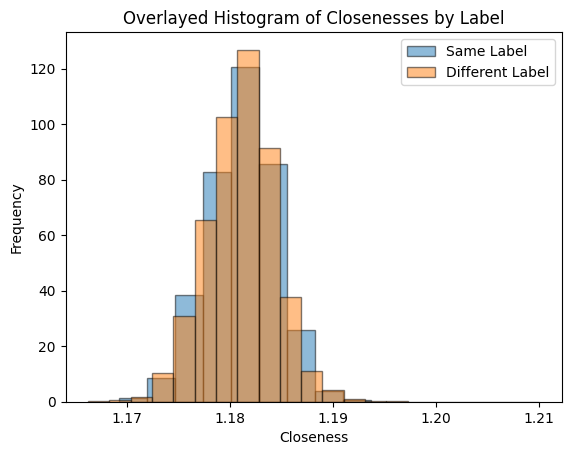

array([1.18540708, 1.18084023, 1.18320454, ..., 1.17846852, 1.18315814,
       1.18232426])

In [130]:
import matplotlib.pyplot as plt

# Exploring the underlying distance distributions of weak and strong queries
def explore_closness_of_index(result_df, index):
    """finds how close index is to all others
    and returns key metrics
    """

    #getting the partitions being analyzed
    df = result_df.reset_index(drop=True)
    item = df.loc[index]
    df_other = df.drop(index, axis=0)

    #getting the embeddings
    embedding = np.array(item['prompt_embedding'])
    other_embeddings = np.array(list(df_other['prompt_embedding'].values))

    #getting labels of what model should be chosen
    item_label = round(item['winner_label'])
    other_labels = round(df_other['winner_label'])

    #weight, as previously defined, is essentially just cosine similarity normalized,
    #so I can use that to conveniently calculate closeness
    weights = calculate_weight(embedding, embeddings, gamma=1.1)

    # Separate closeness values based on whether they match the target label
    same_label_closenesses = [c for c, l in zip(weights, other_labels) if l == item_label]
    different_label_closenesses = [c for c, l in zip(weights, other_labels) if l != item_label]

    # Plot the overlayed histogram
    plt.hist(same_label_closenesses, bins=15, alpha=0.5, label='Same Label', edgecolor='black', density=True)
    plt.hist(different_label_closenesses, bins=15, alpha=0.5, label='Different Label', edgecolor='black', density=True)

    # Add labels and legend
    plt.xlabel('Closeness')
    plt.ylabel('Frequency')
    plt.title('Overlayed Histogram of Closenesses by Label')
    plt.legend()

    # Display the plot
    plt.show()

    return weights

explore_closness_of_index(result_df, 4)

# Note:
I find it unlikely that such a simple model as this Bradley-Terry model can seperate these two gaussians. There is no appreciable difference in distance between queries which require the same model and queries which require a different model.

I do think a model could be trained to embed this information, something like a CLIP style model perhaps, but using an off the shelf general encoder for this task seems dubious.

So, I'm going to move onto the other method.